<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/gluonts_/HAWAII_June30(predicting_July1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install solarforecastarbiter
!pip install TimezoneFinder
# !pip instal
!pip install -q gluonts
!pip install lightning
!pip install "gluonts[torch]"
!pip install "gluonts[mxnet]"
# !pip uninstall mxnet --yes
#!pip install mxnet-cu112
import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday

from gluonts.mx.distribution.gaussian import GaussianOutput
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.mx.model.tft import TemporalFusionTransformerEstimator
#from gluonts.mx.model.deepar import DeepAREstimator
#from gluonts.mx.model.deepstate import DeepStateEstimator
#from gluonts.mx.model.seq2seq import MQCNNEstimator
from solarforecastarbiter.io import api

#from .lightning_module import DeepARLightningModule


#from gluonts.mx.model.deep_npts import  DeepNPTSEstimator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

Mounted at /content/drive


# Functions

In [ ]:
def TimeZoning(lon, lati, df):
    tf = TimezoneFinder(in_memory=True)
    local_time_zone = tf.timezone_at(lng=lon, lat=lati)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.tz_localize(tz = 'UTC').dt.tz_convert(tz=local_time_zone)
    return df




In [ ]:
#Gives crps_scores
#The lower the score, the better
def scorer(df, predictor, context_days, prediction_days,sum_bool):
        crps_score = []
        df3 = df
        times = []
        for month in range(5,9):
            if month in set([1,3,5,7,8,10]):
                days = 31
            elif month in set([4,6,9,11]):
                days = 30
            else:
                days = 28
            for day in range(1,days + 1):
                    print("day",month, day)
                    target_time = "2022-{:02d}-{:02d} 00:00:00".format(month,day)
                    # target_time = '2022-06-01 00:00:00'
                    test = df3[df3['timestamp'] >= pd.Timestamp(target_time)][:24*(context_days + prediction_days)]
                    times.append(pd.Timestamp(target_time))
                    data_list = [{"start": target_time,
                                  "target": test['value'].values,
                                  'feat_dynamic_real':test.drop(columns = ['value', 'timestamp']).T,
                                  }]
                    train_ds_test  = ListDataset(data_iter=data_list,freq='1H')


                    forecast_it, ts_it = make_evaluation_predictions(
                        dataset=train_ds_test,  # dataset
                        predictor=predictor,  # predictor
                        num_samples=500,  # number of sample paths we want for evaluation
                    )

                    forecasts = list(forecast_it)
                    tss = list(ts_it)

                    fx_prob = np.zeros((24,11))
                    constant_values = np.array([x/10 for x in range(0,11)])
                    for i in range(11):
                        fx_prob[:, i] = constant_values[i]
                    preds = np.zeros((24,11))
                    for i in range(11):
                        preds[:,i] = forecasts[0].quantile(i/10)[-24:]
                    score = continuous_ranked_probability_score(obs = test['value'][-24:].values, fx = preds, fx_prob = fx_prob)

                    crps_score.append(score)
        if (sum_bool == True):
            return sum(crps_score)

        return crps_score,times

In [ ]:
#Gives us the the output of putting a test set (test_df) through the model
#Gives us a visualization of the model
def predictor(model, test_df, cut_off_date, context_days, prediction_days):
    time_of_choice = pd.Timestamp(cut_off_date)
    target_time = time_of_choice - pd.Timedelta(unit = 'H', value = 24 * context_days)

    test = test_df[test_df['timestamp'] >= pd.Timestamp(target_time)][:24 * (context_days + prediction_days)]

    data_list = [{"start": target_time,
                  "target": test['value'].values,
                  'feat_dynamic_real':test.drop(columns = ['value', 'timestamp']).T}]
    train_ds_test  = ListDataset(data_iter=data_list,freq='1H')
    prediction_intervals = [i/10 for i in range(11)]

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=train_ds_test,  # dataset
        predictor=model,  # predictor
        num_samples=1000,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    for forecast in forecasts:
        forecast.plot(intervals=prediction_intervals, color='g')
    for ts in tss:
        ts.plot(ax=ax,label = 'ts')
    return forecast, tss

In [ ]:
def predictor_fn2(model, test_df, cut_off_date, context_days, prediction_days,offset = 0):
    time_of_choice = pd.Timestamp(cut_off_date)
    target_time = time_of_choice - pd.Timedelta(unit = 'H', value = 24 * context_days)

    test = test_df[test_df['timestamp'] >= pd.Timestamp(target_time)][:24 * (context_days + prediction_days) + offset]

    data_list = [{"start": target_time,
                  "target": test['value'].values,
                  'feat_dynamic_real':test.drop(columns = ['value', 'timestamp']).T}]
    train_ds_test  = ListDataset(data_iter=data_list,freq='1H')
    prediction_intervals = [i/10 for i in range(11)]

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=train_ds_test,  # dataset
        predictor=model,  # predictor
        num_samples=1000,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    for forecast in forecasts:
        forecast.plot(intervals=prediction_intervals, color='g')
    for ts in tss:
        ts.plot(ax=ax,label = 'ts')
    return forecast, tss

In [ ]:
from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return

In [ ]:
def cat_to_num(df,col_name):
  encoded_df = pd.get_dummies(df[col_name], prefix= col_name +'_encoded')
  df_encoded = pd.concat([df, encoded_df], axis=1)
  df_encoded = df_encoded.drop(col_name,axis = 1)
  return df_encoded

# Model Training Set Creation

Train on 2022 Summer data for now, will integrate 2023 summer data into training as competition progresses.

In [ ]:
tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736

In [ ]:
df_data_1 = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/hawaii_2022-01-01-2023-06-15_historical.csv')
df_data_1.head()
df_data_1



,time,value,quality_flag,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2022-01-01 01:00:00,0.607660,0,21.7,94,20.7,25.1,0.2,55,32,35,16,0.0,0.0,0.0,0.0,2022-01-01T18:03,2022-01-01T07:09
1,2022-01-01 02:00:00,0.542128,0,22.0,93,20.9,25.8,0.4,73,42,56,6,0.0,0.0,0.0,0.0,2022-01-01T18:03,2022-01-01T07:09
2,2022-01-01 03:00:00,0.485958,0,22.0,95,21.2,25.8,0.1,59,33,43,13,0.0,0.0,0.0,0.0,2022-01-01T18:03,2022-01-01T07:09
3,2022-01-01 04:00:00,0.457872,0,21.5,95,20.7,25.0,0.2,47,29,28,13,0.0,0.0,0.0,0.0,2022-01-01T18:03,2022-01-01T07:09
4,2022-01-01 05:00:00,0.457021,0,20.8,93,19.7,24.0,0.3,72,56,32,8,0.0,0.0,0.0,0.0,2022-01-01T18:03,2022-01-01T07:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12692,2023-06-14 20:00:00,0.810213,18,25.5,78,21.3,27.7,0.0,27,17,19,0,1.0,0.0,1.0,17.0,2023-06-14T19:17,2023-06-14T05:48
12693,2023-06-14 21:00:00,0.796596,18,25.4,78,21.2,27.3,0.0,20,14,13,0,0.0,0.0,0.0,0.0,2023-06-14T19:17,2023-06-14T05:48
12694,2023-06-14 22:00:00,0.737872,18,25.3,78,21.1,27.0,0.0,12,9,7,0,0.0,0.0,0.0,0.0,2023-06-14T19:17,2023-06-14T05:48
12695,2023-06-14 23:00:00,0.674042,18,24.4,82,21.1,26.5,0.0,5,3,3,0,0.0,0.0,0.0,0.0,2023-06-14T19:17,2023-06-14T05:48


In [ ]:
df_data_1.columns

Index(['time', 'value', 'quality_flag', 'temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
       'precipitation', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance', 'sunset', 'sunrise'],
      dtype='object')

I dont know about the idea of using hours and month as a numerical feature. Might be a better idea to perform one-hot encoding

In [ ]:
df_data_1.time = pd.to_datetime(df_data_1.time)
training_data = df_data_1
training_data['hours'] = (training_data.time.dt.hour - 12) / 24
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = ((training_data.sunrise.dt.hour - 12) / 24) + ((training_data.sunrise.dt.minute - 30) / 60)
training_data.sunset = ((training_data.sunset.dt.hour - 12) / 24) + ((training_data.sunset.dt.minute - 30) / 60)
training_data['month'] = training_data.time.dt.month
training_data = training_data.drop('quality_flag', axis = 1)
training_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month
0,2022-01-01 01:00:00,0.607660,21.7,94,20.7,25.1,0.2,55,32,35,16,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.458333,1
1,2022-01-01 02:00:00,0.542128,22.0,93,20.9,25.8,0.4,73,42,56,6,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.416667,1
2,2022-01-01 03:00:00,0.485958,22.0,95,21.2,25.8,0.1,59,33,43,13,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.375000,1
3,2022-01-01 04:00:00,0.457872,21.5,95,20.7,25.0,0.2,47,29,28,13,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.333333,1
4,2022-01-01 05:00:00,0.457021,20.8,93,19.7,24.0,0.3,72,56,32,8,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.291667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12692,2023-06-14 20:00:00,0.810213,25.5,78,21.3,27.7,0.0,27,17,19,0,1.0,0.0,1.0,17.0,0.075,0.008333,0.333333,6
12693,2023-06-14 21:00:00,0.796596,25.4,78,21.2,27.3,0.0,20,14,13,0,0.0,0.0,0.0,0.0,0.075,0.008333,0.375000,6
12694,2023-06-14 22:00:00,0.737872,25.3,78,21.1,27.0,0.0,12,9,7,0,0.0,0.0,0.0,0.0,0.075,0.008333,0.416667,6
12695,2023-06-14 23:00:00,0.674042,24.4,82,21.1,26.5,0.0,5,3,3,0,0.0,0.0,0.0,0.0,0.075,0.008333,0.458333,6


In [ ]:
#2023 removal. This should also be done for test sets that include these dates
training_data = training_data[(training_data['time'] <= '2023-03-14 02:00:00') | (training_data['time'] >= '2023-03-23 00:00:00')]


#2022 removal
training_data = training_data[(training_data['time'] <= '2022-01-18 00:00:00') | (training_data['time'] >= '2022-01-23 19:00:00')]

In [ ]:

# import os, types
# import pandas as pd
# from botocore.client import Config
# import ibm_boto3

# def __iter__(self): return 0

# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share the notebook.
# cos_client = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='wgRiOmtzMipfudqoaC6FTskc7MXV3Wa6BdEM0MmzSRLo',
#     ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

# bucket = 'netloadforecasting-donotdelete-pr-0ohp7llqznyypb'
# object_key = 'or_hrrr_new.csv'

# body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# df_data_1 = pd.read_csv(body)

In [ ]:
# cols = df_data_1.columns.drop(['time','timestamp', 'Unnamed: 0'])
# scaler = StandardScaler()

# # Normalize all columns using Z-score normalization
# cols = df_data_1.columns.drop(['time','timestamp','Unnamed: 0'])
# df_normalized = pd.DataFrame(scaler.fit_transform(df_data_1[cols]), columns= cols)

# # Print the normalized DataFrame
# #df_normalized['timestamp'] = df_data_1['timestamp']
# df_normalized.insert(0, 'timestamp', df_data_1['timestamp'])
# df = df_normalized
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df

In [ ]:
# df = df_data_1
# df = df.drop(['Unnamed: 0'], axis = 1)
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df

In [ ]:
df.columns

In [ ]:
# #Cleaning and Normalizing
# #df = df_data_1.drop(columns = ['index', 'Unnamed: 0.1', 'Unnamed: 0'])
# df = df_data_1.drop(columns = ['index', 'Unnamed: 0.1', 'Unnamed: 0','apcp','prate'])
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df['hour'] = (df['timestamp'].dt.hour - 12 )/ 24
# df['tmp'] =(df['tmp'] - df['tmp'].mean() ) / df['tmp'].std()
# df['rh'] =( df['rh'] - df['rh'].mean() ) / df['rh'].std()
# df['tcc'] =( df['tcc'] - df['tcc'].mean() ) / df['tcc'].std()
# df['dswrf'] =( df['dswrf'] - df['dswrf'].mean() ) / df['dswrf'].std()
# df['dpt'] =( df['dpt'] - df['dpt'].mean() ) / df['dpt'].std()

# df['hour'] = (df['timestamp'].dt.hour - 12 )/ 24
# df

In [ ]:
training_data= training_data.rename(columns = {'time':'timestamp'})

In [ ]:
#Making training data
#We only have numerical features, no categorical features
df = training_data
start = "2022-04-01 00:00:00"
end = "2022-09-01 00:00:00"
data_list = [{"start": start,
              "target": df[(df['timestamp'] >= pd.Timestamp(start))&
                          (df['timestamp'] <= pd.Timestamp(end))]['value'].values,
              'feat_dynamic_real':df[(df['timestamp'] >= pd.Timestamp(start))&
                          (df['timestamp'] <= pd.Timestamp(end))].drop(columns = ['value', 'timestamp']).T,
              }]
train_ds2  = ListDataset(data_iter=data_list,freq='1H')

#Refined Train Ds

In [ ]:
training_data

,timestamp,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month
0,2022-01-01 01:00:00,0.607660,21.7,94,20.7,25.1,0.2,55,32,35,16,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.458333,1
1,2022-01-01 02:00:00,0.542128,22.0,93,20.9,25.8,0.4,73,42,56,6,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.416667,1
2,2022-01-01 03:00:00,0.485958,22.0,95,21.2,25.8,0.1,59,33,43,13,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.375000,1
3,2022-01-01 04:00:00,0.457872,21.5,95,20.7,25.0,0.2,47,29,28,13,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.333333,1
4,2022-01-01 05:00:00,0.457021,20.8,93,19.7,24.0,0.3,72,56,32,8,0.0,0.0,0.0,0.0,-0.200,-0.558333,-0.291667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12692,2023-06-14 20:00:00,0.810213,25.5,78,21.3,27.7,0.0,27,17,19,0,1.0,0.0,1.0,17.0,0.075,0.008333,0.333333,6
12693,2023-06-14 21:00:00,0.796596,25.4,78,21.2,27.3,0.0,20,14,13,0,0.0,0.0,0.0,0.0,0.075,0.008333,0.375000,6
12694,2023-06-14 22:00:00,0.737872,25.3,78,21.1,27.0,0.0,12,9,7,0,0.0,0.0,0.0,0.0,0.075,0.008333,0.416667,6
12695,2023-06-14 23:00:00,0.674042,24.4,82,21.1,26.5,0.0,5,3,3,0,0.0,0.0,0.0,0.0,0.075,0.008333,0.458333,6


In [ ]:
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

In [ ]:
train4 = cat_to_num(training_data,'month')
train5 = train4.drop(['hours','sunrise','sunset','month'],axis = 1)

numerical_feats = train5.columns.drop(['timestamp','value'])
#categorical_feats = training_data[['month']].columns
targ = train5['value'].values
start = "2022-01-01 00:00:00"

data = {
    FieldName.TARGET: targ,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: train5[numerical_feats].values
    #FieldName.FEAT_STATIC_CAT: training_data[categorical_feats].astype(str).values.reshape(-1)
}

data = [data]

# Create the ListDataset
train_ds_5 = ListDataset(
    data,
    freq='H',  # Frequency of the time series data (hourly data)
    one_dim_target=True,  # Set to True if target is one-dimensional
)

In [ ]:
train5

,timestamp,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,month_encoded_3,month_encoded_4,month_encoded_5,month_encoded_6,month_encoded_7,month_encoded_8,month_encoded_9,month_encoded_10,month_encoded_11,month_encoded_12
0,2022-01-01 01:00:00,0.607660,21.7,94,20.7,25.1,0.2,55,32,35,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-01 02:00:00,0.542128,22.0,93,20.9,25.8,0.4,73,42,56,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-01 03:00:00,0.485958,22.0,95,21.2,25.8,0.1,59,33,43,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-01 04:00:00,0.457872,21.5,95,20.7,25.0,0.2,47,29,28,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-01 05:00:00,0.457021,20.8,93,19.7,24.0,0.3,72,56,32,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12692,2023-06-14 20:00:00,0.810213,25.5,78,21.3,27.7,0.0,27,17,19,...,0,0,0,1,0,0,0,0,0,0
12693,2023-06-14 21:00:00,0.796596,25.4,78,21.2,27.3,0.0,20,14,13,...,0,0,0,1,0,0,0,0,0,0
12694,2023-06-14 22:00:00,0.737872,25.3,78,21.1,27.0,0.0,12,9,7,...,0,0,0,1,0,0,0,0,0,0
12695,2023-06-14 23:00:00,0.674042,24.4,82,21.1,26.5,0.0,5,3,3,...,0,0,0,1,0,0,0,0,0,0


# Test Data Set Creation

In [ ]:
hi_test_set = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/hawaii_2023-06-30_test.csv')

In [ ]:
hi_test_set.time = pd.to_datetime(hi_test_set.time)

training_data = hi_test_set
training_data['hours'] = (training_data.time.dt.hour - 12) / 24
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = ((training_data.sunrise.dt.hour - 12) / 24) + ((training_data.sunrise.dt.minute - 30) / 60)
training_data.sunset = ((training_data.sunset.dt.hour - 12) / 24) + ((training_data.sunset.dt.minute - 30) / 60)
training_data['month'] = training_data.time.dt.month
training_data = training_data.drop('quality_flag', axis = 1)
hi_test = training_data
hi_test

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,0,0.0,0.0,0.0,0.0,-0.008333,0.008333,-0.458333,6
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,0,0.0,0.0,0.0,0.0,-0.008333,0.008333,-0.416667,6
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,0,0.0,0.0,0.0,0.0,-0.008333,0.008333,-0.375000,6
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,0,0.0,0.0,0.0,0.0,-0.008333,0.008333,-0.333333,6
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,0,0.0,0.0,0.0,0.0,-0.008333,0.008333,-0.291667,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,26.4,69,20.3,28.2,0.0,34,34,0,0,131.0,97.0,34.0,602.3,0.125000,0.091667,0.291667,7
787,2023-07-03 20:00:00,NaN,25.5,74,20.5,27.6,0.0,33,33,0,0,14.0,10.0,4.0,48.0,0.125000,0.091667,0.333333,7
788,2023-07-03 21:00:00,NaN,25.1,76,20.5,27.3,0.0,48,35,0,19,0.0,0.0,0.0,0.0,0.125000,0.091667,0.375000,7
789,2023-07-03 22:00:00,NaN,25.0,76,20.5,27.3,0.0,63,36,0,37,0.0,0.0,0.0,0.0,0.125000,0.091667,0.416667,7


In [ ]:
hi_test = cat_to_num(hi_test,'month')
hi_test = hi_test.drop(['hours','sunrise','sunset'],axis = 1)
hi_test

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,month,month_encoded_6,month_encoded_7
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,0,0.0,0.0,0.0,0.0,6,1,0
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,0,0.0,0.0,0.0,0.0,6,1,0
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,0,0.0,0.0,0.0,0.0,6,1,0
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,0,0.0,0.0,0.0,0.0,6,1,0
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,0,0.0,0.0,0.0,0.0,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,26.4,69,20.3,28.2,0.0,34,34,0,0,131.0,97.0,34.0,602.3,7,0,1
787,2023-07-03 20:00:00,NaN,25.5,74,20.5,27.6,0.0,33,33,0,0,14.0,10.0,4.0,48.0,7,0,1
788,2023-07-03 21:00:00,NaN,25.1,76,20.5,27.3,0.0,48,35,0,19,0.0,0.0,0.0,0.0,7,0,1
789,2023-07-03 22:00:00,NaN,25.0,76,20.5,27.3,0.0,63,36,0,37,0.0,0.0,0.0,0.0,7,0,1


In [ ]:
hi_test[hi_test['value'].isna()== False].tail()

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,month,month_encoded_6,month_encoded_7
666,2023-06-28 19:00:00,0.736170,25.7,69,19.6,27.0,0.0,47,47,0,0,98.0,56.0,42.0,441.9,6,1,0
667,2023-06-28 20:00:00,0.785532,25.2,72,19.8,27.1,0.0,46,46,0,0,2.0,1.0,1.0,25.2,6,1,0
668,2023-06-28 21:00:00,0.762553,24.8,75,20.0,27.0,0.0,37,37,0,0,0.0,0.0,0.0,0.0,6,1,0
669,2023-06-28 22:00:00,0.723404,24.7,75,19.9,27.0,0.0,33,33,0,0,0.0,0.0,0.0,0.0,6,1,0
670,2023-06-28 23:00:00,0.651064,24.5,77,20.2,27.0,0.0,41,41,0,0,0.0,0.0,0.0,0.0,6,1,0


In [ ]:
# hi_test_set['time'] = pd.to_datetime(hi_test_set['time'])
# hi_test_set = hi_test_set.rename(columns={'time': 'timestamp'})
# hi_test_set

### Next cell combines current test set with most recent SFA net-load data. Go to the variable object key in the cell below, and set it equal to the file name containing the most recent SFA net-load data. Note that you must remove meta-data from your csv BEFORE running this cell, or it will error

#BELOW IS ONLY IN CASE WHERE YOUR TEST DATA DOES NOT COME WITH NET LOAD(VALUE) WITHING

In [ ]:
net_loads['timestamp'] = pd.to_datetime(net_loads['timestamp'])
net_loads['timestamp'] = net_loads['timestamp'].dt.tz_localize(None)
net_loads = net_loads.drop('quality_flag', axis = 1)
net_loads

In [ ]:
hi_test = pd.merge(hi_test_set, net_loads, on = 'timestamp', how = 'left')
hi_test

In [ ]:
shared_columns = set(hi_test.columns).intersection(df.columns)
hi_test= hi_test[shared_columns]
df = df[shared_columns]

In [ ]:
yo = df['timestamp']
df = df.drop('timestamp',axis = 1)
df.insert(0, 'timestamp', yo)
df.shape

In [ ]:
yo = hi_test['timestamp']
hi_test = hi_test.drop('timestamp',axis = 1)
hi_test.insert(0, 'timestamp', yo)
hi_test.shape

In [ ]:
hi_test[hi_test['value'].isna()== False].tail()

# Training Models

In [ ]:
import numpy as np

In [ ]:
context_days_nn = 7
prediction_days_nn = 4
context_length = 24 * context_days_nn # train on this number of days
prediction_length = (24 * prediction_days_nn)  # predict these many days, these are removed from the end of the training data



my_dist = GaussianOutput(np.mean(hi_test['value']), np.std(hi_test['value']))
estimator_nn = SimpleFeedForwardEstimator(num_hidden_dimensions=[5],
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=my_dist,
                                       trainer=Trainer(epochs=100,
                                                       learning_rate=1e-2,
                                                       num_batches_per_epoch=100
                                                      ))
predictor_nn = estimator_nn.train(train_ds_5)

100%|██████████| 100/100 [00:01<00:00, 54.82it/s, epoch=100/100, avg_epoch_loss=-.967]


In [ ]:
context_days_nn = 7
prediction_days_nn = 3
context_length = 24 * context_days_nn # train on this number of days
prediction_length = (24 * prediction_days_nn)  # predict these many days, these are removed from the end of the training data



my_dist = GaussianOutput(np.mean(hi_test['value']), np.std(hi_test['value']))
estimator_nn = SimpleFeedForwardEstimator(num_hidden_dimensions=[5],
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=my_dist,
                                       trainer=Trainer(epochs=100,
                                                       learning_rate=1e-2,
                                                       num_batches_per_epoch=100
                                                      ))
predictor_nn2 = estimator_nn.train(train_ds2)

100%|██████████| 100/100 [00:00<00:00, 125.87it/s, epoch=100/100, avg_epoch_loss=-1.21]


In [ ]:
# context_days_nn = 7
# prediction_days_nn = 3
# context_length = 24 * context_days_nn # train on this number of days
# prediction_length = (24 * prediction_days_nn)  # predict these many days, these are removed from the end of the training data

# estimator_nn = SimpleFeedForwardEstimator(num_hidden_dimensions=[5],
#                                        context_length=context_length,
#                                        prediction_length=prediction_length,
#                                        distr_output=GaussianOutput(),
#                                        trainer=Trainer(epochs=50,
#                                                        learning_rate=1e-3,
#                                                        num_batches_per_epoch=100
#                                                       ))
# predictor_nn2 = estimator_nn.train(train_ds)

In [ ]:
# #from gluonts.mx.model.n_beats import *
# context_days_nn = 12
# prediction_days_nn = 11
# context_length = 24 * context_days_nn # train on this number of days
# prediction_length = 24 * prediction_days_nn # predict these many days, these are removed from the end of the training data

# estimator = NBEATSEstimator(
#     context_length= context_length,              # Length of the input context window
#     prediction_length= prediction_length,           # Length of the predicted sequences
#     freq = 'H',
#     num_stacks=3,                  # Number of stacks of the N-BEATS architecture
#     num_blocks= [3],                  # Number of blocks per stack
#     #num_layers= 3,                  # Number of fully connected layers per block
#     #layer_sizes= 300,                 # Sizes of the fully connected layers
#     trainer=Trainer(
#         epochs=30,                   # Number of training epochs
#         learning_rate=1e-3,            # Learning rate for optimization
#         num_batches_per_epoch=100                # Batch size for training
#     )
# )

# # Train the model



# predictor_NNjr = estimator.train(train_ds)

In [ ]:
# context_days_nn = 12
# prediction_days_nn = 11
# context_length = 24 * context_days_nn # train on this number of days
# prediction_length = (24 * prediction_days_nn) # predict these many days, these are removed from the end of the training data

# estimator = DeepNPTSEstimator(
#     context_length = context_length,
#     prediction_length=prediction_length,
#     freq="H",
#     num_feat_dynamic_real = 5,
#     use_feat_static_cat = False,
#     cardinality = [0],
#     trainer=Trainer(
#         epochs=30,                   # Number of training epochs
#         learning_rate=1e-3,            # Learning rate for optimization
#         num_batches_per_epoch=100
#     )
# )
# predictor_DeepS = estimator.train(train_ds)



In [ ]:
# context_days_nn = 12
# prediction_days_nn = 11
# context_length = 24 * context_days_nn # train on this number of days
# prediction_length = 24 * prediction_days_nn # predict these many days, these are removed from the end of the training data

# estimator = NBEATSEstimator(
#     context_length= context_length,              # Length of the input context window
#     prediction_length= prediction_length,           # Length of the predicted sequences
#     freq = 'H',
#     #num_stacks= 3,                  # Number of stacks of the N-BEATS architecture
#     #num_blocks= [3],                  # Number of blocks per stack
#     #num_layers= 3,                  # Number of fully connected layers per block
#     #layer_sizes= 300,                 # Sizes of the fully connected layers
#     trainer=Trainer(
#         epochs=5,                   # Number of training epochs
#         learning_rate=1e-3,            # Learning rate for optimization
#         num_batches_per_epoch=50                # Batch size for training
#     )
# )

# # Train the model
# predictor_NNjr2 = estimator.train(train_ds)

In [ ]:
# context_days_big = 8
# prediction_days_big = 5
# context_length = 24 * context_days_big # train on this number of days
# prediction_length = 24 * prediction_days_big # predict these many days, these are removed from the end of the training data


# estimator_big = DeepAREstimator(prediction_length = prediction_length,
#                             context_length = context_length,
#                             freq = 'H',
#                             num_layers = 3,
#                             num_cells = 64,
#                             use_feat_dynamic_real = True,
#                            trainer=Trainer(
#                                 epochs= 20,
#                                 learning_rate= 1e-3,
#                                 num_batches_per_epoch= 30,
#                             ))
# predictor_DeepAR = estimator_big.train(train_ds)

# Model Evaluation on Training Data

For now, we are predicting on the training data. Thus enter df as the data frame. Cut_off_data is the start time for the predictions. The function cuts the dataframe according to this date

(gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[0.62964875, 0.55605465, 0.5109517 , ..., 0.7927546 , 0.7487289 ,
         0.7216535 ],
        [0.63569003, 0.58043045, 0.5386108 , ..., 0.7891022 , 0.7368219 ,
         0.7440092 ],
        [0.62632674, 0.58651155, 0.5192335 , ..., 0.90900815, 0.7109844 ,
         0.58721817],
        ...,
        [0.61865395, 0.55167884, 0.51947165, ..., 0.7650206 , 0.7124828 ,
         0.65543133],
        [0.6142349 , 0.5645678 , 0.5078581 , ..., 0.8090505 , 0.77995235,
         0.7005619 ],
        [0.65716726, 0.5709455 , 0.5231012 , ..., 0.82221484, 0.7347471 ,
         0.6657217 ]], dtype=float32), start_date=Period('2022-06-22 00:00', 'H')),
 [                         0
  2022-06-15 00:00  0.626383
  2022-06-15 01:00  0.569362
  2022-06-15 02:00  0.530213
  2022-06-15 03:00  0.509787
  2022-06-15 04:00  0.527660
  ...                    ...
  2022-06-24 19:00  0.770213
  2022-06-24 20:00  0.777873
  2022-06-24 21:0

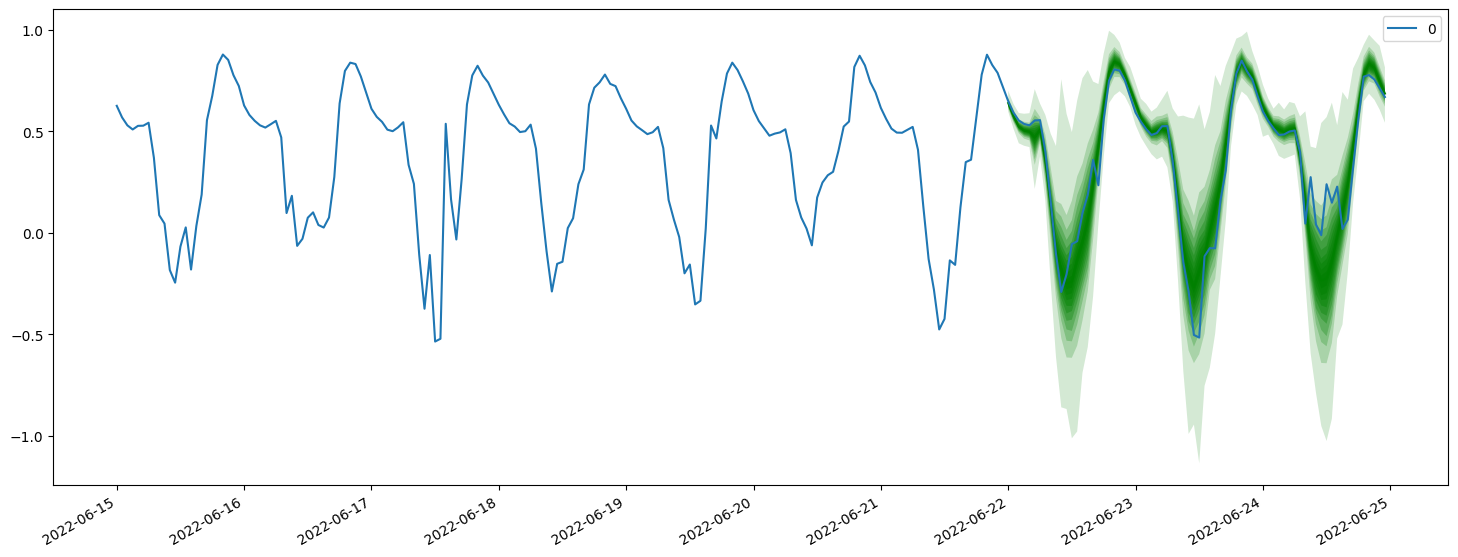

In [ ]:
predictor(predictor_nn, df, "2022-06-22 00:00:00", 7, 3)

(gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[0.6228144 , 0.57341635, 0.5517798 , ..., 0.83008605, 0.7339122 ,
         0.64466953],
        [0.6267363 , 0.57024956, 0.5219428 , ..., 0.755806  , 0.74585927,
         0.66800725],
        [0.63535696, 0.5778275 , 0.54112035, ..., 0.8307096 , 0.71389174,
         0.6713483 ],
        ...,
        [0.6319672 , 0.5684451 , 0.5369432 , ..., 0.7828089 , 0.7208591 ,
         0.673121  ],
        [0.639496  , 0.57630706, 0.53370446, ..., 0.8472569 , 0.72712725,
         0.70039743],
        [0.6194165 , 0.5705142 , 0.53024805, ..., 0.74775726, 0.67743856,
         0.6848192 ]], dtype=float32), start_date=Period('2022-06-22 00:00', 'H')),
 [                         0
  2022-06-15 00:00  0.626383
  2022-06-15 01:00  0.569362
  2022-06-15 02:00  0.530213
  2022-06-15 03:00  0.509787
  2022-06-15 04:00  0.527660
  ...                    ...
  2022-06-24 19:00  0.770213
  2022-06-24 20:00  0.777873
  2022-06-24 21:0

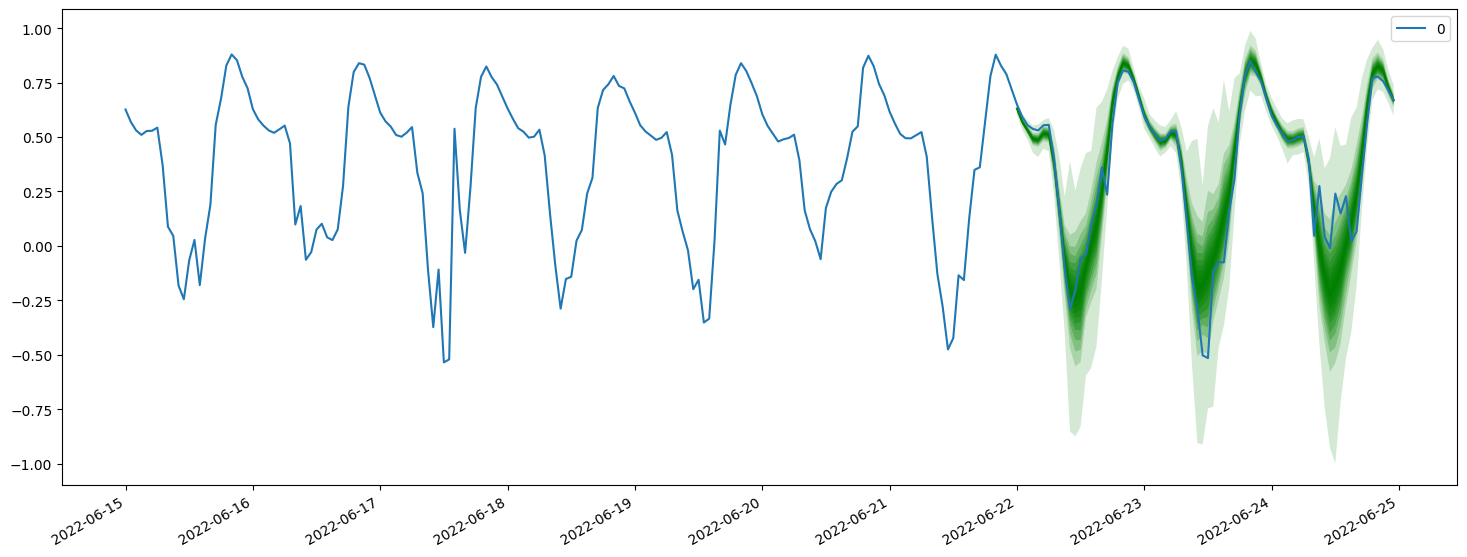

In [ ]:
predictor(predictor_nn2, df, "2022-06-22 00:00:00", 7, 3)

In [ ]:
#predictor(predictor_nn2, df, "2022-06-22 23:00:00", 7, 3)

In [ ]:
#predictor(predictor_NNjr2, df, "2022-06-17 00:00:00", 5, 8)

In [ ]:
#predictor(predictor_DeepAR, df, "2022-06-17 00:00:00", 8, 5)

# Model Predicitons

In [ ]:
HI_forecasts = predictor_fn2(predictor_nn, hi_test, "2023-06-26 23:00:00", 7, 3)

In [ ]:
#HI_forecasts = predictor(predictor_nn2, hi_test, "2023-06-26 23:00:00", 7, 3)

# Uploading Best Predictions

In [ ]:
HI_forecasts

(gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 0.09920298, -0.24711426, -0.19305883, ..., -0.82120144,
         -0.7606449 , -0.7117464 ],
        [-0.4271193 , -0.603186  ,  0.2947118 , ..., -0.01804849,
          0.26481757, -0.06303101],
        [-0.22573872,  0.06688428,  0.19226477, ..., -0.09300153,
          0.3849814 , -0.15572175],
        ...,
        [ 0.09761196, -0.27333546, -0.04865562, ..., -0.22500159,
         -0.5251736 , -0.5256906 ],
        [-0.29657298, -0.3501452 ,  0.17526466, ..., -0.29250622,
         -0.67586803, -0.37233397],
        [ 0.07027236, -0.43689188, -0.11280636, ..., -0.19881496,
         -0.7319261 , -0.32915983]], dtype=float32), start_date=Period('2023-06-26 23:00', 'H')),
 [                         0
  2023-06-19 23:00 -0.433191
  2023-06-20 00:00 -0.111489
  2023-06-20 01:00  0.207660
  2023-06-20 02:00  0.424681
  2023-06-20 03:00  0.527660
  ...                    ...
  2023-06-29 18:00       NaN
  2023-06-

Puts prediction timestamps in appropriate timestamp

In [ ]:
fx_prob = np.zeros((24,11))
constant_values = np.array([x/10 for x in range(0,11)])
for i in range(11):
    fx_prob[:, i] = constant_values[i]
preds = np.zeros((24,11))
for i in range(11):
    preds[:,i] = HI_forecasts[0].quantile(i/10)[-24:]

tf = TimezoneFinder(in_memory=True)
local_time_zone = tf.timezone_at(lng=hi_lon, lat=hi_lat)
hi_test_set['timestamp'] = hi_test_set['timestamp'].dt.tz_localize(local_time_zone)

In [ ]:
hi_test_set[-24-23:-23]

,timestamp,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),precipitation (mm),pressure_msl (hPa),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),is_day (),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²)
673,2023-06-29 01:00:00-10:00,24.2,77,19.9,26.6,0.0,1017.2,31,31,0,0,0,0.0,0.0,0.0,0.0,0.0
674,2023-06-29 02:00:00-10:00,24.1,78,20.0,26.6,0.0,1016.9,25,25,0,0,0,0.0,0.0,0.0,0.0,0.0
675,2023-06-29 03:00:00-10:00,24.1,78,20.0,26.6,0.0,1016.7,13,13,0,0,0,0.0,0.0,0.0,0.0,0.0
676,2023-06-29 04:00:00-10:00,24.0,78,19.9,26.5,0.0,1016.7,9,9,0,0,0,0.0,0.0,0.0,0.0,0.0
677,2023-06-29 05:00:00-10:00,23.9,79,20.0,26.4,0.0,1016.8,22,22,0,0,0,0.0,0.0,0.0,0.0,0.0
678,2023-06-29 06:00:00-10:00,23.8,79,20.0,26.4,0.0,1017.3,28,28,0,0,1,0.0,0.0,0.0,0.0,0.0
679,2023-06-29 07:00:00-10:00,24.4,76,19.9,26.8,0.0,1017.9,26,26,0,0,1,80.0,42.0,38.0,0.0,160.8
680,2023-06-29 08:00:00-10:00,26.0,68,19.6,27.7,0.0,1018.2,28,28,0,0,1,286.0,203.0,83.0,459.1,453.9
681,2023-06-29 09:00:00-10:00,27.5,62,19.5,28.9,0.0,1018.3,34,34,0,0,1,523.0,426.0,97.0,690.6,729.0
682,2023-06-29 10:00:00-10:00,28.5,57,19.1,30.3,0.0,1018.2,35,35,0,0,1,709.0,577.0,132.0,789.3,967.4


In [ ]:
submission2 = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
submission2['timestamp'] = hi_test_set['timestamp'][-24-23:-23]
submission2[['p' + str(i*10) for i in range(11)]] = preds

In [ ]:
submission2

,timestamp,p0,p10,p20,p30,p40,p50,p60,p70,p80,p90,p100
673,2023-06-29 01:00:00-10:00,-1.269739,-0.558742,-0.397710,-0.276120,-0.179024,-0.086143,-0.009855,0.089043,0.190431,0.355334,0.990914
674,2023-06-29 02:00:00-10:00,-1.176975,-0.514933,-0.363717,-0.265980,-0.188193,-0.102248,-0.026708,0.058812,0.165622,0.296428,1.052587
675,2023-06-29 03:00:00-10:00,-1.015998,-0.516191,-0.332932,-0.228032,-0.136637,-0.043969,0.061180,0.156736,0.273598,0.419911,1.121507
676,2023-06-29 04:00:00-10:00,-0.608192,-0.149495,-0.060898,-0.005672,0.070637,0.125204,0.178259,0.235384,0.320809,0.420823,0.876675
677,2023-06-29 05:00:00-10:00,-0.048754,0.172626,0.236647,0.282848,0.322246,0.357800,0.395687,0.428335,0.467562,0.517222,0.723327
678,2023-06-29 06:00:00-10:00,0.384891,0.510197,0.539461,0.558738,0.578965,0.596032,0.611096,0.628233,0.647723,0.678421,0.789692
679,2023-06-29 07:00:00-10:00,0.581215,0.677774,0.697350,0.712142,0.723025,0.733847,0.746535,0.758963,0.771108,0.788016,0.894951
680,2023-06-29 08:00:00-10:00,0.646105,0.734155,0.754369,0.768013,0.781078,0.792946,0.804159,0.815118,0.829089,0.848836,0.927139
681,2023-06-29 09:00:00-10:00,0.628273,0.735944,0.757333,0.768049,0.778340,0.786965,0.797795,0.807325,0.821501,0.837804,0.905439
682,2023-06-29 10:00:00-10:00,0.549763,0.670311,0.690200,0.704379,0.714382,0.726313,0.736998,0.747970,0.762168,0.779686,0.881886


In [ ]:
project.save_data(data=submission2.to_csv(),file_name='hi_submission2_for_June29_on_June28.csv',overwrite=True)

{'file_name': 'or_submission2_for_June29_on_June28.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'netloadforecasting-donotdelete-pr-0ohp7llqznyypb',
 'asset_id': '52cdb77f-be8f-4d8c-8950-7c61b9d8b697'}

In [ ]:
upload_function(submission2.set_index('timestamp'),'hi')